In [1]:
import json
import random
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm

import numpy as np
from PIL import Image

import pandas as pd
from pandas import DataFrame

import os
import sys

from pycocotools.coco import COCO
from tqdm.notebook import tqdm

In [2]:
annotation = '../../../../detection/dataset/train.json' # annotation 경로
coco = COCO(annotation)
annotations = dict(coco.anns)
print(annotations[116])

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
{'image_id': 23, 'category_id': 0, 'area': 342823.66, 'bbox': [233.7, 341.0, 711.4, 481.9], 'iscrowd': 0, 'id': 116}


In [3]:
# prediction_strings = []
# file_names = []
# temp = -1
# file_name = -1
# prediction_string = ''
# for i in tqdm(annotations):
#     prediction_string += {str(annotations[i]['image_id']) : str(annotations[i]['category_id']) + ' ' + str(1) + ' ' + str(annotations[i]['bbox'][0]) + ' ' + str(annotations[i]['bbox'][1]) + ' ' + str(annotations[i]['bbox'][2]) + ' ' + str(annotations[i]['bbox'][3]) + ' '}
#     if file_name != temp :
#         prediction_strings.append(prediction_string)
#         file_names.append(temp)
#         prediction_string = ''
#     file_name = str(annotations[i]['image_id'])
# df = pd.DataFrame()
# df['PredictionString'] = prediction_strings
# df['image_id'] = file_names

prediction_strings = dict()
for i in tqdm(annotations):
    if annotations[i]['image_id'] in prediction_strings:
        prediction_strings[annotations[i]['image_id']] += str(annotations[i]['category_id']) + ' ' + str(1) + ' ' + str(annotations[i]['bbox'][0]) + ' ' + str(annotations[i]['bbox'][1]) + ' ' + str(annotations[i]['bbox'][2]) + ' ' + str(annotations[i]['bbox'][3]) + ' '
    else:
        prediction_strings[annotations[i]['image_id']] = str(annotations[i]['category_id']) + ' ' + str(1) + ' ' + str(annotations[i]['bbox'][0]) + ' ' + str(annotations[i]['bbox'][1]) + ' ' + str(annotations[i]['bbox'][2]) + ' ' + str(annotations[i]['bbox'][3]) + ' '
df = DataFrame()
df['PredictionString'] = prediction_strings.values()
df['image_id'] = prediction_strings.keys()
df

  0%|          | 0/23144 [00:00<?, ?it/s]

PredictionString  image_id
0                          0 1 197.6 193.7 547.8 469.7          0
1     3 1 0.0 407.4 57.6 180.6 7 1 0.0 455.6 144.6 1...         1
2                          3 1 267.9 165.2 631.6 513.0          2
3     2 1 462.2 369.4 233.9 254.6 6 1 773.3 3.0 188....         3
4     1 1 567.5 462.2 165.2 89.4 1 1 859.4 411.7 164...         4
...                                                 ...       ...
4878                       0 1 377.8 370.4 332.4 255.6       4878
4879  5 1 160.5 441.9 186.2 232.1 0 1 660.7 615.6 91...      4879
4880                       0 1 193.3 209.2 576.4 637.4       4880
4881  7 1 114.5 45.2 751.7 472.9 7 1 724.0 69.1 45.0...      4881
4882  5 1 0.0 116.2 944.1 814.1 7 1 302.1 439.3 265....      4882

[4883 rows x 2 columns]

In [6]:
def get_file_path(json_file, image_num):
    file_path = json_file['images'][image_num]['file_name']
    return file_path

def read_image(dataset_path, file_path):
    image = cv2.imread(dataset_path + file_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_annotations(df, image_num):
    # anns = [ann for ann in json_file['annotations'] if ann['image_id'] == image_num]
    labels = []
    anns = []
    ann = []
    
    cur_df = df.loc[image_num]['PredictionString'].split()
    for j, _ in enumerate(cur_df):
        if j % 6 == 0:
            labels.append(int(cur_df[j]))
        elif j % 6 == 1:
            continue
        else:
            ann.append(float(cur_df[j]))
            if len(ann) == 4:
                anns.append(ann)
                ann = []
    return anns, labels

def plot_bbox(image_list, anns, labels):
    classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")
    # one picture size
    fig_size = 7
    # num of pictures in one raw
    cols = 4
    
    # num of raw is setted by num of all picture and cols
    if len(image_list)%cols == 0 :
        raws = len(image_list)//cols
    else :
        raws = len(image_list)//cols + 1
    fig = plt.figure(figsize=(cols*fig_size+1 ,fig_size*(len(image_list)//cols + 1)))#
    for i, image in enumerate(image_list) :
        for ann, label in zip(anns[i], labels[i]):
            color = list(np.random.random(size=3) * 256)
            xmin, ymin, xmax, ymax = ann
            randnum = random.randint(-40,41)
            image_list[i] = cv2.putText(image, classes[label], (int((xmin)), int((ymin+ymax)/2)+randnum), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)
            image_list[i] = cv2.rectangle(image, (int(xmin),int(ymin)), (int(xmax)+int(xmin), int(ymax)+int(ymin)), color, 3)
            ax = fig.add_subplot(raws, cols, i+1)
            ax.imshow(image_list[i])
            ax.set_xticks([]), ax.set_yticks([])
    fig.tight_layout()
    plt.show()    
    
def plot_box(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image)

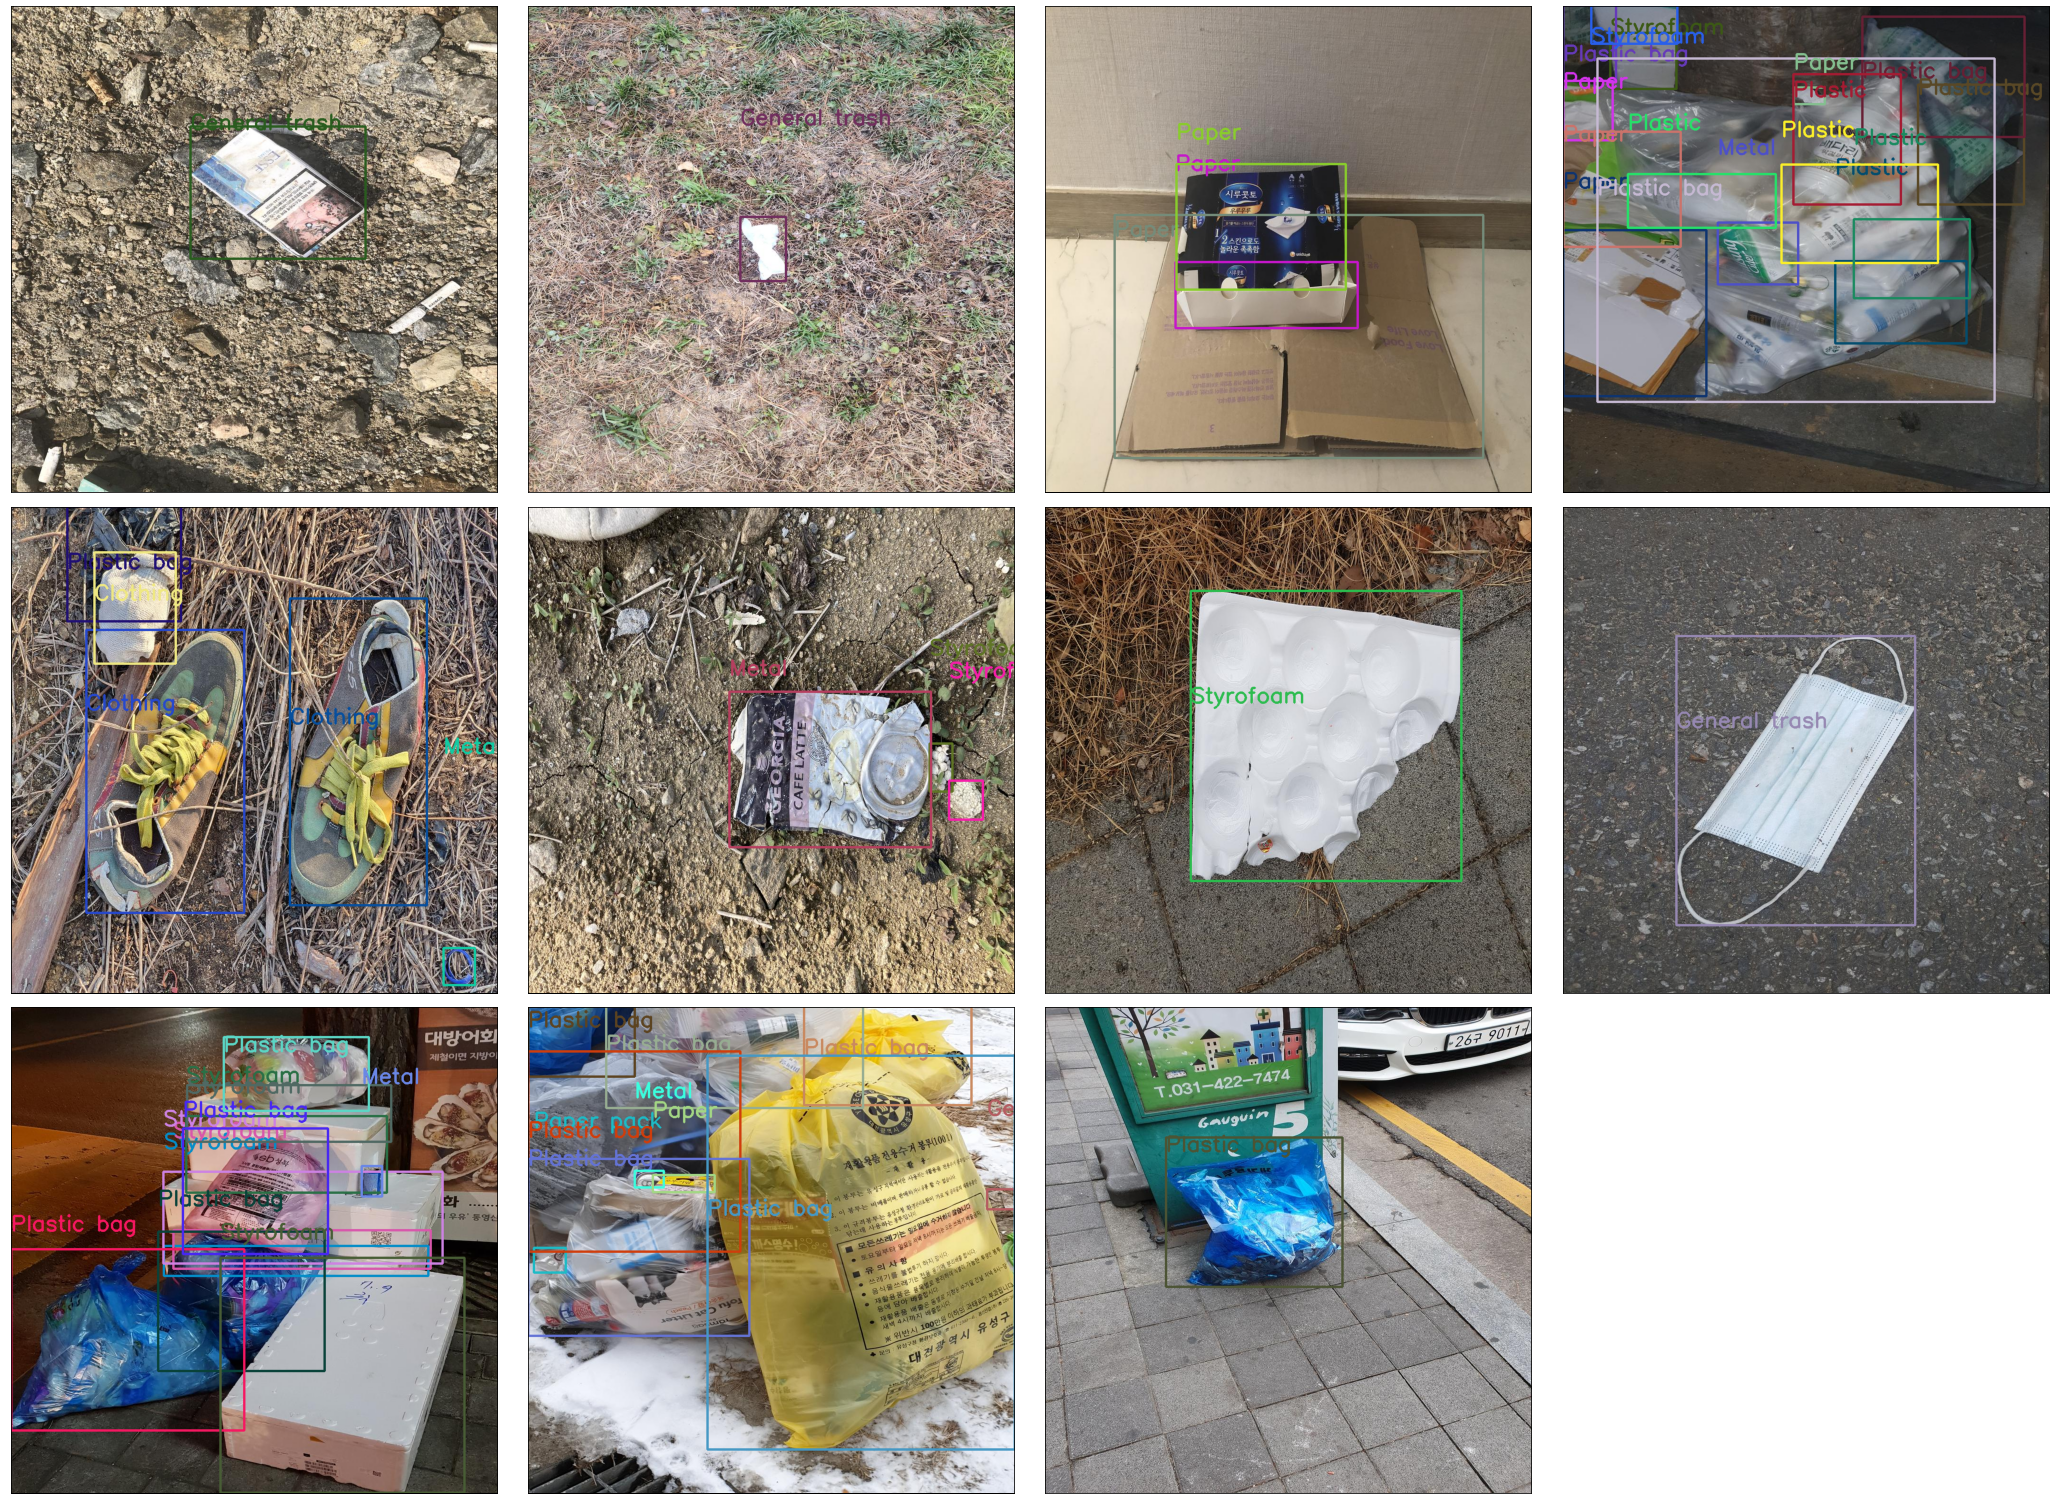

In [9]:
with open('../../../dataset/train.json','r') as f:
    test_json = json.load(f)
dataset_path = '../../../dataset/'
image_list = []
anns_list = []
labels_list = []

# set image range
start = 10
finish = 20
for i in range(start, finish+1) :
    image_number = i
    file_path = get_file_path(test_json, image_number)
    anns, labels = get_annotations(df, image_number)
    image = read_image(dataset_path, file_path)
    image_list.append(image)
    anns_list.append(anns)
    labels_list.append(labels)
    
# plot_box(image)
plot_bbox(image_list, anns_list, labels_list)
